Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from create_det_map import get_det_map, calc_centroid

 Load in the data:

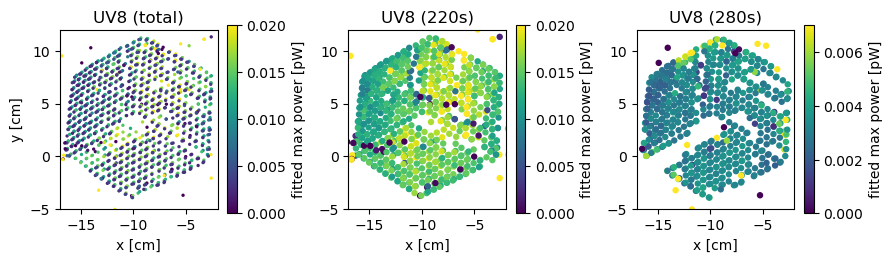

In [2]:
data = np.load("/Users/talford/Downloads/20230306_uv8_fits.npy", allow_pickle=True)

poses = np.array([[data.item()[k][v] for v in [
    'x_pos', 'y_pos', 'amp_pW', 'msk_220',
    'msk_280']] for k in data.item().keys()])
pos_220 = poses[poses[:, 3] == 1]
pos_280 = poses[poses[:, 4] == 1]

fig, axes = plt.subplots(1, 3, figsize=(9, 5), sharey=False)
cols = axes[0].scatter(poses[:, 0], poses[:, 1], c=abs(poses[:, 2]), s=2, vmin=0, vmax=0.02)
plt.colorbar(cols, ax=axes[0], shrink=.4, label='fitted max power [pW]')
cols = axes[1].scatter(pos_220[:, 0], pos_220[:, 1], c=abs(pos_220[:, 2]), s=13, vmin=0, vmax=0.02)
plt.colorbar(cols, ax=axes[1], shrink=.4, label='fitted max power [pW]')
cols = axes[2].scatter(pos_280[:, 0], pos_280[:, 1], c=abs(pos_280[:, 2]), s=13, vmin=0, vmax=.007)
plt.colorbar(cols, ax=axes[2], shrink=.4, label='fitted max power [pW]')
#plt.colorbar(cols, ax=axes, label='fitted max power [pA]')
for ax in axes:
    ax.set_xlim(-17, -2)
    ax.set_ylim(-5, 12)
    ax.set_xlabel('x [cm]')
    ax.set_aspect('equal')
axes[0].set_ylabel('y [cm]')
axes[0].set_title('UV8 (total)')
axes[1].set_title('UV8 (220s)')
axes[2].set_title('UV8 (280s)')
plt.tight_layout()
plt.show()

 Prune the data so that we remove high and low end power pixels that are likely dark or saturated:

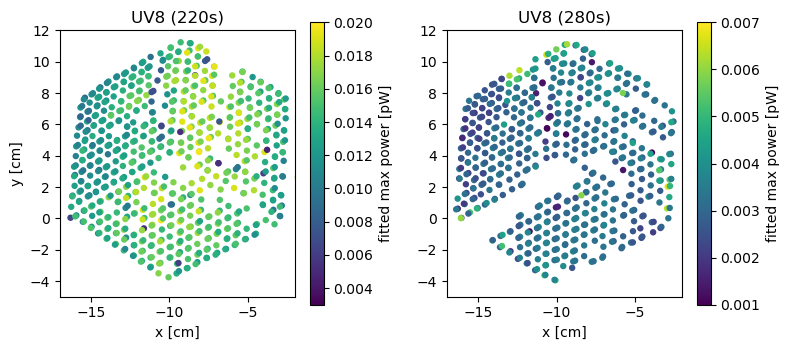

In [3]:
pos_220_good_power = pos_220[(abs(pos_220[:, 2]) > .004) & (abs(pos_220[:, 2]) < .02)]
pos_280_good_power = pos_280[(abs(pos_280[:, 2]) > .001) & (abs(pos_280)[:, 2] < .007)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
cols = axes[0].scatter(pos_220_good_power[:, 0], pos_220_good_power[:, 1], c=abs(
    pos_220_good_power[:, 2]), s=13, vmin=.003, vmax=.02)
plt.colorbar(cols, ax=axes[0], shrink=.8, label='fitted max power [pW]')
cols = axes[1].scatter(pos_280_good_power[:, 0], pos_280_good_power[:, 1],
                       c=abs(pos_280_good_power[:, 2]), s=13, vmin=.001, vmax=.007)
plt.colorbar(cols, ax=axes[1], shrink=.8, label='fitted max power [pW]')
#plt.colorbar(cols, ax=axes, label='fitted max power [pA]')
for ax in axes:
    ax.set_xlim(-17, -2)
    ax.set_ylim(-5, 12)
    ax.set_xlabel('x [cm]')
    ax.set_aspect('equal')
axes[0].set_ylabel('y [cm]')
axes[0].set_title('UV8 (total)')
axes[0].set_title('UV8 (220s)')
axes[1].set_title('UV8 (280s)')
plt.tight_layout()
plt.show()

 Create a dataframe with the data for easier processing:

In [4]:
table = {'x_pos': [], 'y_pos': [], 'amp_pW': [], 'msk_220': [], 'msk_280': [],
         'band': [], 'channel': [], 'amp_phase': [], 'x_fwhm': [], 'y_fwhm': [],
         'readout_id': []}
for (band, channel), beam_data in data.item().items():
    table['band'].append(band)
    table['channel'].append(channel)
    for (key, value) in beam_data.items():
        table[key].append(value)

df = pd.DataFrame(table)
df['amp_pW'] = abs(df['amp_pW'])

good_220s = (df['msk_220'] & ((df['amp_pW'] > .004) & (df['amp_pW'] < .02)))
good_280s = (df['msk_280'] & ((df['amp_pW'] > .001) & (df['amp_pW'] < .007)))
good_df = df[good_220s | good_280s]

good_220 = good_df[good_df['msk_220']]
good_280 = good_df[good_df['msk_280']]

print('df shape = ', good_df.shape)

df shape =  (1311, 11)


Make the det map:

Can use verbose level = 2 if you want to get more in the weeds.

In [6]:
final_pixel_map_uv8, _, _ = get_det_map(good_df, verbose=1)

Number of interesting return values = 27
Number of repeats found = 12. Choosing single pixels for each.
Number of one-ofs found = 29. Checking to possibly assign each to other pixels.
Final number of one-ofs = 27.
Number of pixels with >2 of one frequency type = 0


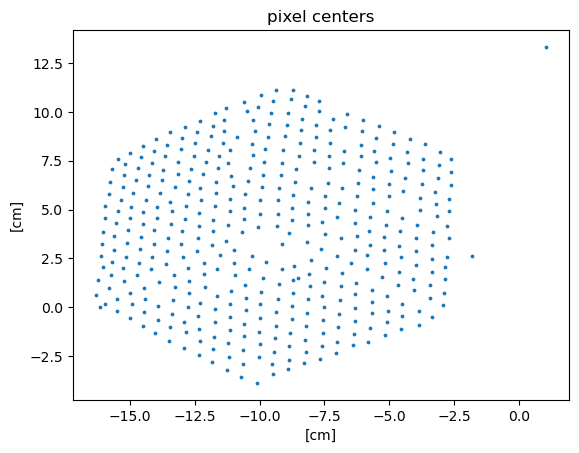

In [9]:
centroid_list = [calc_centroid(p) for p in final_pixel_map_uv8]
cs = np.array(centroid_list)
plt.scatter(cs[:, 0], cs[:, 1], s=3)
plt.xlabel('[cm]')
plt.ylabel('[cm]')
plt.title('pixel centers')
plt.show()

 Looks pretty good! Except for a few side pixels which we can just ignore.

 If we want to examine the 220s and 280s a little more closely with the det map:

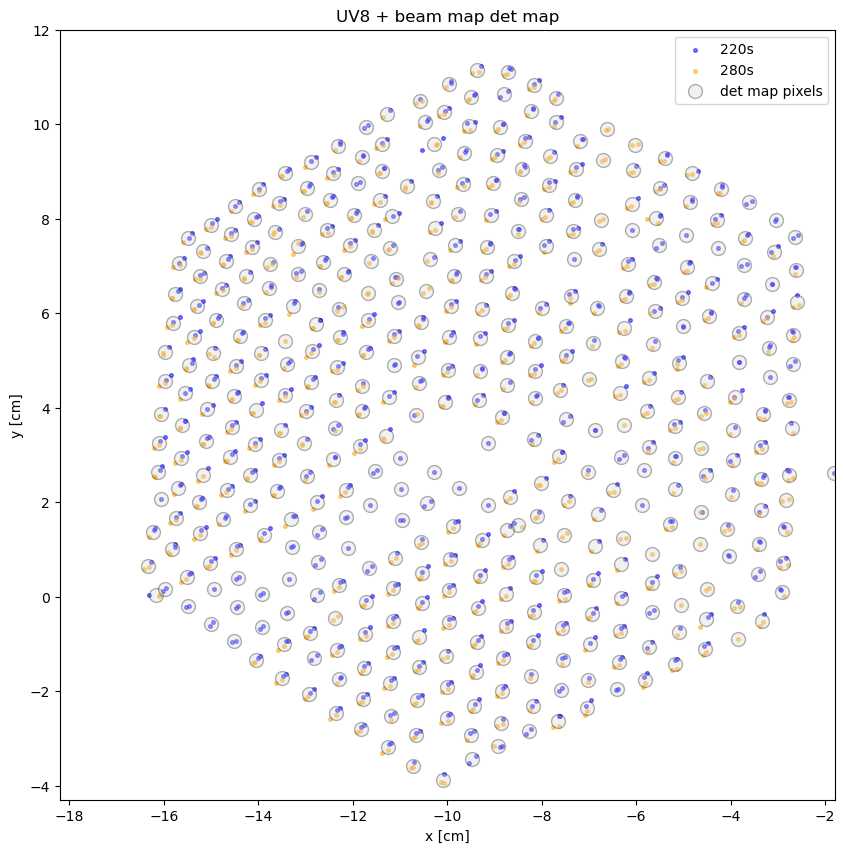

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(good_220['x_pos'], good_220['y_pos'], color="blue", s=7, alpha=.5, label='220s')
plt.scatter(good_280['x_pos'], good_280['y_pos'], color="orange", s=7, alpha=.5, label='280s')
plt.scatter(cs[:, 0], cs[:, 1], s=100, color="lightgray", alpha=.3, edgecolors='black',
            label='det map pixels')
plt.axis('equal')
plt.xlim(-17, -3)
plt.ylim(-4.3, 12.0)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.title('UV8 + beam map det map')
plt.legend()
plt.show()